In [205]:
import pandas as pd

Getting Papers from DB

In [ ]:
import mysql.connector
import csv

conn = mysql.connector.connect(
    host='127.0.0.1',
    port=3306,
    user='root',
    password='tianxiadiyiHaoMiMA!!!OK?',
    database='predatory'
)
cursor = conn.cursor()

cursor.execute("""
    SELECT id,title,authors,publication_date,publisher,description,pdf_link,website,total_citations
    FROM papers
""")

with open('papers.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f,
                        delimiter=',',
                        quotechar='"',
                        quoting=csv.QUOTE_ALL)

    writer.writerow([d[0] for d in cursor.description])

    for row in cursor:
        writer.writerow(row)

cursor.close()
conn.close()

print("Export complete: papers.csv")


<h2>Prepare Data</h2>
docs (title list)
abstracts (description list)

In [206]:
good_papers = pd.read_csv('/home/yuying/Documents/scholar/DB_convert/5.5/good/papers.csv')
bad_papers = pd.read_csv('/home/yuying/Documents/scholar/DB_convert/5.5/bad/papers.csv')

In [207]:
good_papers['dataset'] = 'good'
bad_papers['dataset'] = 'bad'

combined_papers = pd.concat([good_papers, bad_papers], ignore_index=True)

In [208]:
combined_papers

,id,title,authors,publication_date,publisher,description,pdf_link,website,total_citations,dataset
0,1,Monitoring depression trends on Twitter during...,"Yipeng Zhang, Hanjia Lyu, Yubao Liu, Xiyang Zh...",2021,JMIR infodemiology,Background The COVID-19 pandemic has affected ...,https://infodemiology.jmir.org/2021/1/e26769,https://infodemiology.jmir.org/2021/1/e26769,141,good
1,2,Social physics,"M Jusup, P Holme, K Kanazawa, M Takayasu, I Romić",NaN,NaN,Recent decades have seen a rise in the use of ...,https://www.sciencedirect.com/science/article/...,https://www.sciencedirect.com/science/article/...,422,good
2,3,BERT-deep CNN: State of the art for sentiment ...,"JH Joloudari, S Hussain, MA Nematollahi",NaN,NaN,The COVID-19 pandemic has led to the emergence...,https://arxiv.org/pdf/2211.09733,https://link.springer.com/article/10.1007/s132...,51,good
3,4,The longest month: analyzing COVID-19 vaccinat...,"LA Cotfas,C Delcea,I Roxin,C Ioanăş,DS Gherai,...",2021,Ieee Access,The coronavirus outbreak has brought unprecede...,https://ieeexplore.ieee.org/iel7/6287639/65148...,https://ieeexplore.ieee.org/abstract/document/...,164,good
4,5,COVID-19 outbreak: An ensemble pre-trained dee...,"SJ Malla,PJA Alphonse",2021,Applied Soft Computing,"On 11 March 2020, the (WHO) World Health Organ...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9...,https://www.sciencedirect.com/science/article/...,88,good
...,...,...,...,...,...,...,...,...,...,...
16022,8760,Self-Organized Genetic Algorithm for Enhanced ...,"Dinesh Karunanidy, V Vyshnavi, M Sai Soumya Re...",2023.0,NaN,This study introduces a self-organized genetic...,NaN,https://ieeexplore.ieee.org/abstract/document/...,0,bad
16023,8761,An Opposition-based Grey Wolf Optimization for...,"Rajakumar Ramalingam, K Dinesh, M Sreedevi, Ab...",2022.0,NaN,Clustering is considered one of the practical ...,https://www.researchsquare.com/article/rs-1785...,https://www.researchsquare.com/article/rs-1785...,0,bad
16024,8762,Dynamics of digital pen-tablet: handwriting an...,"Tahmid Hasan, Md Abdur Rahim, Jungpil Shin, Sa...",2024.0,IEEE Access,Handwriting is controlled by neurons in the br...,https://ieeexplore.ieee.org/iel7/6287639/65148...,https://ieeexplore.ieee.org/abstract/document/...,2,bad
16025,8763,An Enhanced Hybrid Model Based on CNN and BiLS...,"MA Rahim,FA Farid, A SalehMusaMiah, AK Puza,MN...",2024.0,CMES-Computer Modeling in Engineering & Sciences,Handwriting is a unique and significant human ...,https://cdn.techscience.cn/files/CMES/2024/TSP...,https://cdn.techscience.cn/files/CMES/2024/TSP...,0,bad


In [209]:
docs = [title for title in combined_papers['title'].tolist() if title != ''] 
abstracts = [
    description
    for description in combined_papers['description']
    if isinstance(description, str) and description.strip() != ''
]

In [210]:
abstracts #the data used later for topic modelling

['Background The COVID-19 pandemic has affected people’s daily lives and has caused economic loss worldwide. Anecdotal evidence suggests that the pandemic has increased depression levels among the population. However, systematic studies of depression detection and monitoring during the pandemic are lacking. Objective This study aims to develop a method to create a large-scale depression user data set in an automatic fashion so that the method is scalable and can be adapted to future events; verify the effectiveness of transformer-based deep learning language models in identifying depression users from their everyday language; examine psychological text features’ importance when used in depression classification; and, finally, use the model for monitoring the fluctuation of depression levels of different groups as the disease propagates. Methods To study this subject, we designed an effective regular expression-based search method and created the largest English Twitter depression data 

<h2>Topic Modeling</h2>
<h3>BERTopic</h3>

In [211]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/yuying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yuying/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [212]:
import os
from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect
import re
import spacy
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from hdbscan import HDBSCAN
from umap import UMAP

from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance

In [ ]:
import importlib.metadata as im
print(im.version("hdbscan"))         


0.8.39


In [215]:
def train_bertopic(num_topics, cleaned_docs):
    """
    Trains a BERTopic model with a specified number of topics.
    
    Args:
        num_topics (int): Number of topics for BERTopic.
        cleaned_docs (list): List of preprocessed text documents.

    Returns:
        BERTopic model and topic assignments.
    """
    # Custom components
    umap_model = UMAP(n_neighbors=15, n_components=10, metric="cosine")
    hdbscan_model = HDBSCAN(min_cluster_size=50, min_samples=5, metric="euclidean", prediction_data=True) # min_cluster_size change
    vectorizer_model = CountVectorizer(stop_words="english", max_df=0.85, min_df=1)
    # vectorizer_model = CountVectorizer(stop_words="english", min_df=10) # CountVectorizer to remove stopwords
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # Reduce impact of frequent words
    representation_model = KeyBERTInspired() # Reduce apperance of stop words
    # representation_model = MaximalMarginalRelevance(diversity=0.7)
    

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model="all-mpnet-base-v2",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model,

        # zeroshot_min_similarity=1,
        
        top_n_words=5,
        nr_topics=num_topics,
        min_topic_size=50, # Change number of comments in each topic
        calculate_probabilities=True
        
    )

    # Fit model
    print(f"Training BERTopic with {num_topics} topics...")
    topics, _ = topic_model.fit_transform(cleaned_docs)
    print(f"Model training complete for {num_topics} topics!")

    parent_dir = "/home/yuying/Documents/scholar/analysis/topic_generation/models"
    os.makedirs(parent_dir, exist_ok=True)

    model_dir = os.path.join(parent_dir, f"bertopic_{num_topics}")
    topic_model.save(model_dir)
    print(f"✔️ Model saved to {model_dir}")

    return topic_model, topics

In [216]:
def analyze_topics_and_assign(docs, combined_papers, num_topics):
    topic_model, topics = train_bertopic(num_topics, docs)
    probs = topic_model.probabilities_
    topics_reduced = topic_model.reduce_outliers(
        documents=docs,
        topics=topics,
        strategy="distributions",
        probabilities=probs,
        threshold=0.05
    )
    combined_papers["topic_title_{}".format(num_topics)] = topics_reduced

    topic_distr, _ = topic_model.approximate_distribution(docs)
    topic_distr_df = pd.DataFrame(topic_distr)
    #combined_papers = pd.concat([combined_papers.reset_index(drop=True), topic_distr_df.reset_index(drop=True)], axis=1)
    combined_papers = pd.concat([combined_papers.reset_index(drop=False)], axis=1)

    fig = topic_model.visualize_heatmap()
    z_matrix = fig['data'][0]['z']
    topic_labels = fig['data'][0]['x']
    similarity_df = pd.DataFrame(z_matrix, index=topic_labels, columns=topic_labels)

    good_papers_with_topic = combined_papers[combined_papers["dataset"] == "good"]
    bad_papers_with_topic = combined_papers[combined_papers["dataset"] == "bad"]

    return topic_model, topics, similarity_df, good_papers_with_topic, bad_papers_with_topic

In [217]:
from scipy.cluster import hierarchy as sch
import numpy as np
import pandas as pd

def analyze_abstracts(docs, combined_papers, num_topics):
    # Step 1: Train model
    topic_model, topics = train_bertopic(num_topics, docs)

    # Step 2: Reduce outliers
    probs = topic_model.probabilities_
    topics_reduced = topic_model.reduce_outliers(
        documents=docs,
        topics=topics,
        strategy="distributions",
        probabilities=probs,
        threshold=0.05
    )

    # Step 3: Assign topics to valid abstracts only
    valid_mask = combined_papers['description'].apply(lambda x: isinstance(x, str) and x.strip() != '')
    topic_col_name = f"topic_title_abs_{num_topics}"
    combined_papers[topic_col_name] = np.nan
    combined_papers.loc[valid_mask, topic_col_name] = topics_reduced

    # Step 4: Add topic distribution
    topic_distr, _ = topic_model.approximate_distribution(docs)
    topic_distr_df = pd.DataFrame(topic_distr)
    combined_papers = pd.concat([combined_papers.reset_index(drop=False)], axis=1)

    # Step 5: Similarity matrix from heatmap
    fig = topic_model.visualize_heatmap()
    z_matrix = fig['data'][0]['z']
    topic_labels = fig['data'][0]['x']
    similarity_df = pd.DataFrame(z_matrix, index=topic_labels, columns=topic_labels)

    # Step 6: Hierarchical clustering
    linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
    hierarchical_topics = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)

    # Step 7: Split into good and bad sets
    good_papers_with_topic = combined_papers[combined_papers["dataset"] == "good"]
    bad_papers_with_topic = combined_papers[combined_papers["dataset"] == "bad"]

    return topic_model, topics, similarity_df, good_papers_with_topic, bad_papers_with_topic, hierarchical_topics


In [ ]:
# Use title to trian
topic_model_30, topics_30, similarity_df_30, good_df_30, bad_df_30 = analyze_topics_and_assign(docs, combined_papers, num_topics=30)

In [219]:
# Use abstract to train
# topic_model_30_abs, topics_30_abs, similarity_df_30_abs, good_df_30_abs, bad_df_30_abs = analyze_abstracts(abstracts, combined_papers, num_topics=30)

model, topics, sim_df, good, bad, hierarchical = analyze_abstracts(abstracts, combined_papers, num_topics=30)

Training BERTopic with 30 topics...


2025-07-01 23:27:26,306 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Model training complete for 30 topics!
✔️ Model saved to /home/yuying/Documents/scholar/analysis/topic_generation/models/bertopic_30


100%|██████████| 28/28 [00:03<00:00,  7.84it/s]


In [221]:
bad

,index,id,title,authors,publication_date,publisher,description,pdf_link,website,total_citations,dataset,topic_title_abs_30
8299,8299,1,AI Chatbot integration in SME marketing platfo...,"Wagobera Edgar Kedi, Chibundom Ejimuda, Courag...",2024.0,International Journal of Management & Entrepre...,This review paper examines the integration of ...,https://www.fepbl.com/index.php/ijmer/article/...,https://www.fepbl.com/index.php/ijmer/article/...,6,bad,1.0
8300,8300,2,Transforming financial data centers for Fintec...,"OS Osundare,AB Ige",2024.0,Computer Science & IT Research Journal,This review paper explores the transformative ...,https://www.fepbl.com/index.php/csitrj/article...,https://www.fepbl.com/index.php/csitrj/article...,0,bad,1.0
8301,8301,3,Accelerating Fintech optimization and cybersec...,"OS Osundare,AB Ige",2024.0,Engineering Science & Technology Journal,This review paper explores the profound impact...,https://www.fepbl.com/index.php/estj/article/d...,https://www.fepbl.com/index.php/estj/article/v...,0,bad,1.0
8302,8302,4,Building resilience in small businesses throug...,"TN Odonkor, O Urefe, EE Agu, S Obeng",2024.0,International Journal of Management & Entrepre...,In an increasingly volatile and competitive bu...,https://www.fepbl.com/index.php/ijmer/article/...,https://www.fepbl.com/index.php/ijmer/article/...,0,bad,2.0
8303,8303,5,Comprehensive financial strategies for achievi...,"TN Odonkor, O Urefe, E Biney, S Obeng",2024.0,Finance & Accounting Research Journal,Sustainable growth in small businesses is a cr...,https://fepbl.com/index.php/farj/article/view/...,https://fepbl.com/index.php/farj/article/view/...,0,bad,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16022,16022,8760,Self-Organized Genetic Algorithm for Enhanced ...,"Dinesh Karunanidy, V Vyshnavi, M Sai Soumya Re...",2023.0,NaN,This study introduces a self-organized genetic...,NaN,https://ieeexplore.ieee.org/abstract/document/...,0,bad,26.0
16023,16023,8761,An Opposition-based Grey Wolf Optimization for...,"Rajakumar Ramalingam, K Dinesh, M Sreedevi, Ab...",2022.0,NaN,Clustering is considered one of the practical ...,https://www.researchsquare.com/article/rs-1785...,https://www.researchsquare.com/article/rs-1785...,0,bad,9.0
16024,16024,8762,Dynamics of digital pen-tablet: handwriting an...,"Tahmid Hasan, Md Abdur Rahim, Jungpil Shin, Sa...",2024.0,IEEE Access,Handwriting is controlled by neurons in the br...,https://ieeexplore.ieee.org/iel7/6287639/65148...,https://ieeexplore.ieee.org/abstract/document/...,2,bad,0.0
16025,16025,8763,An Enhanced Hybrid Model Based on CNN and BiLS...,"MA Rahim,FA Farid, A SalehMusaMiah, AK Puza,MN...",2024.0,CMES-Computer Modeling in Engineering & Sciences,Handwriting is a unique and significant human ...,https://cdn.techscience.cn/files/CMES/2024/TSP...,https://cdn.techscience.cn/files/CMES/2024/TSP...,0,bad,25.0


Load Models

In [ ]:
model.visualize_hierarchy(hierarchical_topics=hierarchical)

KL score

https://mallet.cs.umass.edu/diagnostics.php : We calculate distance using Kullback-Leibler divergence. A greater distance means the topic is more distinct; a smaller distanace means that the topic is more similar to the corpus distribution. 

In [222]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv = CountVectorizer()
X = cv.fit_transform(docs + abstracts)

word_counts = np.asarray(X.sum(axis=0)).ravel()
P_bg = (word_counts + 1) / (word_counts.sum() + len(word_counts))
vocab = cv.vocabulary_

def kl_score_for_topic(topic_id):
    
    score = 0.0
    for word, p_tw in model.get_topic(topic_id):
        idx = vocab.get(word)
        if idx is None:
            continue
        score += p_tw * np.log(p_tw / P_bg[idx])
    return score

n_topics = len(model.get_topic_info()) - 1

raw_scores = np.array([kl_score_for_topic(i) for i in range(n_topics)])

norm_scores = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min())

import pandas as pd
topic_scores_df = pd.DataFrame({
    "topic_id": np.arange(n_topics),
    "kl_raw":   raw_scores,
    "kl_norm":  norm_scores
})

topic_scores_df_sorted = topic_scores_df.sort_values("kl_norm", ascending=True)
print(topic_scores_df_sorted)


    topic_id     kl_raw   kl_norm
0          0  22.499505  0.000000
4          4  23.006767  0.022368
1          1  26.628584  0.182077
5          5  26.750366  0.187447
10        10  27.360101  0.214334
17        17  28.258991  0.253972
3          3  29.231850  0.296871
7          7  29.551683  0.310974
13        13  30.742598  0.363489
20        20  31.364197  0.390899
2          2  32.150315  0.425564
19        19  33.654358  0.491887
25        25  33.676810  0.492877
9          9  34.158567  0.514121
12        12  34.404846  0.524981
15        15  34.690674  0.537585
22        22  34.807574  0.542739
8          8  35.687530  0.581542
18        18  36.159911  0.602372
16        16  37.227388  0.649444
11        11  37.353378  0.655000
21        21  38.375556  0.700074
24        24  38.625864  0.711112
26        26  38.957903  0.725753
27        27  39.425404  0.746368
23        23  39.975163  0.770611
6          6  42.572623  0.885149
14        14  43.696187  0.934694
28        28  

In [223]:
# Use mallet method

# Revised MALLET‑style `corpus_dist` Calculation

import numpy as np
import pandas as pd

vectorizer = model.vectorizer_model
X_bg = vectorizer.transform(docs + abstracts)      
word_counts = np.asarray(X_bg.sum(axis=0)).ravel()  
P_bg = word_counts / word_counts.sum()              

vocab = vectorizer.vocabulary_

def corpus_dist(topic_id):
    score = 0.0
    for word, p_tw in model.get_topic(topic_id):
        idx = vocab.get(word)
        if idx is None:
            continue
        score += p_tw * np.log(p_tw / P_bg[idx])
    return score

topic_ids = model.get_topic_info().query("Topic >= 0")["Topic"].astype(int).tolist()

raw_scores = np.array([corpus_dist(t) for t in topic_ids])
norm_scores = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min())

topic_scores_df = pd.DataFrame({
    "topic_id": topic_ids,
    "corpus_dist": raw_scores,
    "corpus_dist_norm": norm_scores
}).sort_values("corpus_dist", ascending=False).reset_index(drop=True)

topic_scores_df


,topic_id,corpus_dist,corpus_dist_norm
0,28,42.060085,1.000000
1,14,38.716885,0.851140
2,6,38.085771,0.823039
3,27,35.775886,0.720188
4,23,35.521325,0.708854
5,26,35.154558,0.692523
6,21,34.641015,0.669657
7,24,34.457609,0.661491
8,16,33.359534,0.612597
9,11,33.333653,0.611445


Hierarchical score

In [244]:
c_tf_idf = model.c_tf_idf_                      # shape = [(K+1), V]
row_sums  = np.asarray(c_tf_idf.sum(axis=1)).ravel()
row_sums[row_sums == 0] = 1
phi_all   = c_tf_idf.multiply(1/row_sums[:, None]).toarray()
topic_labels = list(map(int, model.topic_labels_))
mask      = [lbl != -1 for lbl in topic_labels]
phi       = phi_all[mask, :]                    # shape = [K, V]

from scipy.spatial.distance     import pdist
from scipy.cluster.hierarchy    import linkage
distances = pdist(phi, metric='cosine')         

Z = linkage(distances, method='single')

def hierarchical_score(linkage_matrix, n_topics):
    scores = np.zeros(n_topics)
    for c1, c2, dist, _ in linkage_matrix:
        i1, i2 = int(c1), int(c2)
        if i1 < n_topics and scores[i1] == 0:
            scores[i1] = dist
        if i2 < n_topics and scores[i2] == 0:
            scores[i2] = dist
    return scores

n_topics     = phi.shape[0]
hier_scores   = hierarchical_score(Z, n_topics)
hier_norm     = (hier_scores - hier_scores.min()) / (hier_scores.max() - hier_scores.min())

import pandas as pd
df_hier = pd.DataFrame({
    'topic_id':   np.arange(n_topics),
    'hier_score': hier_scores,
    'hier_norm':  hier_norm
}).sort_values('hier_norm', ascending=True).reset_index(drop=True)

print(df_hier)


    topic_id  hier_score  hier_norm
0          1    0.401491   0.000000
1          2    0.401491   0.000000
2          4    0.432911   0.086629
3          9    0.452359   0.140249
4         13    0.472436   0.195604
5          8    0.481292   0.220021
6          3    0.518661   0.323054
7          0    0.541786   0.386812
8         10    0.561836   0.442093
9         19    0.601888   0.552523
10        18    0.602615   0.554524
11        16    0.605741   0.563145
12         7    0.606436   0.565059
13        23    0.630512   0.631441
14        14    0.650755   0.687254
15         6    0.650755   0.687254
16        15    0.656691   0.703619
17        20    0.667893   0.734505
18        12    0.669064   0.737735
19        17    0.671096   0.743338
20        11    0.671096   0.743338
21         5    0.689400   0.793803
22        25    0.692479   0.802293
23        22    0.697560   0.816301
24        21    0.721460   0.882198
25        24    0.742568   0.940393
26        27    0.749634   0

entropy

In [225]:
import numpy as np
import pandas as pd

c_tf_idf = model.c_tf_idf_
row_sums = np.asarray(c_tf_idf.sum(axis=1)).ravel()
row_sums[row_sums == 0] = 1
phi_all = c_tf_idf.multiply(1 / row_sums[:, None]).toarray()  # shape = [(K+1), V]

topic_labels = list(map(int, model.topic_labels_))  # e.g. [-1, 0, 1, …]
mask = [lbl != -1 for lbl in topic_labels]
phi = phi_all[mask, :]  # shape = [K, V]

eps = 1e-12
entropy = -np.sum(phi * np.log(phi + eps), axis=1)        # shape = [K,]
entropy_norm = entropy / np.log(phi.shape[1])             # shape = [K,], in [0,1]

df_entropy = pd.DataFrame({
    "topic_id":      np.arange(phi.shape[0]),
    "entropy":       entropy,
    "entropy_norm":  entropy_norm
})

df_entropy = df_entropy.sort_values("entropy_norm", ascending=True).reset_index(drop=True)
print(df_entropy)



    topic_id   entropy  entropy_norm
0         27  6.904856      0.640611
1         28  6.927785      0.642739
2         26  7.206052      0.668555
3         24  7.357253      0.682583
4         25  7.448036      0.691006
5         21  7.577289      0.702998
6         23  7.671413      0.711730
7         22  7.795105      0.723206
8         20  7.873277      0.730459
9         15  8.030627      0.745057
10        13  8.039200      0.745852
11        18  8.043918      0.746290
12        19  8.052555      0.747091
13        16  8.137022      0.754928
14        14  8.259056      0.766250
15        17  8.343578      0.774092
16         8  8.370679      0.776606
17         9  8.452895      0.784234
18        11  8.468157      0.785650
19         7  8.487261      0.787422
20         6  8.611352      0.798935
21        10  8.631709      0.800824
22         1  8.655876      0.803066
23        12  8.734742      0.810383
24         4  8.759405      0.812671
25         2  8.802667      0.816685
2

试图复刻Topic Signi cance Ranking of LDA Generative Models的方法

In [226]:
# Revised TSR Implementation with Safe Metrics Handling

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

# 0. Prerequisites: docs, abstracts, model already defined

# 1. Get document-topic distribution
_, probs = model.transform(docs)  # probs: shape (D, K)

# 2. Build φ (topic-word distribution) and remove noise topic
c_tf_idf = model.c_tf_idf_
row_sums = np.array(c_tf_idf.sum(axis=1)).ravel()
row_sums[row_sums == 0] = 1
phi_all = c_tf_idf.multiply(1 / row_sums[:, None]).toarray()

topic_labels = list(map(int, model.topic_labels_))  # includes -1
mask = [lbl != -1 for lbl in topic_labels]
phi = phi_all[mask, :]  # shape: [K, V]

# 3. Topic prior p_k aligned with phi rows
topic_info = model.get_topic_info()
count_map = dict(zip(topic_info.Topic.astype(int), topic_info.Count))
labels_no_noise = [lbl for lbl in topic_labels if lbl != -1]
p_k = np.array([count_map[lbl] for lbl in labels_no_noise], dtype=float)
p_k /= p_k.sum()  # shape: [K,]

# 4. Reference distributions
V = phi.shape[1]
D = len(docs)

P_U = np.ones(V) / V           # Uniform over words
P_V = p_k.dot(phi)             # Vacuous empirical word distribution
P_B = np.ones(D) / D           # Uniform over documents

# 5. Background corpus distribution (aligned)
vectorizer = model.vectorizer_model
X_bg = vectorizer.transform(docs + abstracts)
counts_bg = np.asarray(X_bg.sum(axis=0)).ravel()
P_bg = counts_bg / counts_bg.sum()

# 6. Safe metric functions
def safe_kl(p, q):
    mask = p > 0
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

def safe_cos(a, b):
    c = cosine(a, b)
    return 1.0 if np.isnan(c) else c

def safe_corr_dist(a, b):
    if np.std(a) == 0 or np.std(b) == 0:
        return 1.0
    return 1 - pearsonr(a, b)[0]

# 7. Compute metrics
n_topics = phi.shape[0]
KL_U = np.zeros(n_topics)
KL_V = np.zeros(n_topics)
KL_B = np.zeros(n_topics)
COS_U = np.zeros(n_topics)
COS_V = np.zeros(n_topics)
COS_B = np.zeros(n_topics)
COR_U = np.zeros(n_topics)
COR_V = np.zeros(n_topics)
COR_B = np.zeros(n_topics)

for k in range(n_topics):
    pk = phi[k]
    theta_k = probs[:, k]

    # KL divergence
    KL_U[k] = safe_kl(pk, P_U)
    KL_V[k] = safe_kl(pk, P_V)
    KL_B[k] = safe_kl(theta_k, P_B)

    # Cosine dissimilarity
    COS_U[k] = safe_cos(pk, P_U)
    COS_V[k] = safe_cos(pk, P_V)
    COS_B[k] = safe_cos(theta_k, P_B)

    # Correlation distance
    COR_U[k] = safe_corr_dist(pk, P_U)
    COR_V[k] = safe_corr_dist(pk, P_V)
    COR_B[k] = safe_corr_dist(theta_k, P_B)

# 8. Normalization and weighting (Eq.10–15)
def rel_std(x):
    return x * ((x.sum() - x) / x.sum())

RU = rel_std(KL_U)
RV = rel_std(KL_V)
RB = rel_std(KL_B)

scaler = MinMaxScaler()
SU2 = scaler.fit_transform(KL_U.reshape(-1,1)).ravel()
SV2 = scaler.fit_transform(KL_V.reshape(-1,1)).ravel()
SB2 = scaler.fit_transform(KL_B.reshape(-1,1)).ravel()

psi_u1, psi_v1 = 0.6, 0.4
S_hat = RB * (psi_u1 * RU + psi_v1 * RV)

Psi_hat = 0.25 * SU2 + 0.25 * SV2 + 0.5 * SB2
TSR = Psi_hat * S_hat

# 9. Compile results
tsr_df = pd.DataFrame({
    "topic_id": np.arange(n_topics),
    "KL_U": KL_U, "KL_V": KL_V, "KL_B": KL_B,
    "COS_U": COS_U, "COS_V": COS_V, "COS_B": COS_B,
    "COR_U": COR_U, "COR_V": COR_V, "COR_B": COR_B,
    "S_hat": S_hat, "Psi_hat": Psi_hat, "TSR": TSR
}).sort_values("TSR", ascending=False).reset_index(drop=True)

tsr_df


/tmp/ipykernel_236498/1317421038.py:57: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



,topic_id,KL_U,KL_V,KL_B,COS_U,COS_V,COS_B,COR_U,COR_V,COR_B,S_hat,Psi_hat,TSR
0,1,2.122664,0.949698,11703.403981,0.682366,0.249942,0.631029,1.0,0.277414,NaN,16630.184817,0.546690,9091.551692
1,2,1.975873,1.004666,11178.769318,0.656252,0.288233,0.651590,1.0,0.335318,NaN,15363.461244,0.513510,7889.288790
2,4,2.019135,1.042250,8183.214390,0.661787,0.289302,0.705141,1.0,0.334455,NaN,11922.603831,0.389101,4639.091907
3,0,1.883599,1.161013,7311.907139,0.643440,0.378206,0.704933,1.0,0.453366,NaN,10540.957118,0.350274,3692.225052
4,9,2.325645,1.306981,5741.250768,0.709844,0.359964,0.727885,1.0,0.401327,NaN,10074.480114,0.350781,3533.940651
5,6,2.167187,1.657281,4945.757889,0.687739,0.537304,0.780527,1.0,0.630322,NaN,8953.564728,0.343958,3079.649708
6,5,1.720546,1.676302,5123.906034,0.606751,0.567040,0.777195,1.0,0.710117,NaN,8057.519787,0.302666,2438.736290
7,8,2.407860,1.327069,4366.866430,0.722470,0.366560,0.778317,1.0,0.403639,NaN,8000.496750,0.301327,2410.763818
8,17,2.434961,2.075616,3117.768003,0.721826,0.588506,0.818057,1.0,0.675135,NaN,6679.171012,0.349448,2334.023715
9,13,2.739340,1.414682,3569.167614,0.763424,0.364187,0.805709,1.0,0.381561,NaN,7346.412833,0.315825,2320.181585


In [227]:
topic_info_df = model.get_topic_info()

In [228]:
sim_df

,0_descriptors_maps_spatial,1_ai_automation_predictive,2_fintech_marketing_entrepr...,3_twitter_sentiment_pandemic,4_sustainability_sustainabl...,5_ligands_ligand_anticancer,6_steatohepatitis_cirrhosis...,7_caregivers_carers_dementia,8_pedagogical_literacy_educ...,9_cybersecurity_fintech_sec...,...,19_dental_cnns_convolutional,20_fda_oncology_pharmacovig...,21_satisfiability_hypergrap...,22_autism_gaze_stimuli,23_agribusiness_agriculture...,24_citations_publication_pu...,25_forecasting_forecasts_so...,26_evolutionary_coevolution...,27_uav_uavs_heuristics,28_testability_testable_tes...
0_descriptors_maps_spatial,1.000000,0.282487,0.022143,0.412098,0.143937,0.001433,-0.023129,0.013405,0.156178,0.300689,...,0.529463,-0.050722,0.290970,0.249935,-0.012321,0.035189,0.356331,0.045090,0.253353,0.036112
1_ai_automation_predictive,0.282487,1.000000,0.615450,0.545772,0.555575,-0.046249,0.034753,0.170340,0.468980,0.665559,...,0.455182,0.214694,0.331837,0.228614,0.273526,0.328245,0.409789,0.333113,0.331880,0.262689
2_fintech_marketing_entrepr...,0.022143,0.615450,1.000000,0.332674,0.537414,-0.059501,0.031172,0.369284,0.467472,0.310298,...,0.096416,0.223402,-0.001481,0.172245,0.486194,0.395253,0.084071,0.363766,0.111501,0.104393
3_twitter_sentiment_pandemic,0.412098,0.545772,0.332674,1.000000,0.270937,0.008882,0.113990,0.371957,0.460627,0.458908,...,0.430635,0.219540,0.350232,0.336769,0.106677,0.382512,0.342801,0.374745,0.153710,0.134789
4_sustainability_sustainabl...,0.143937,0.555575,0.537414,0.270937,1.000000,0.023631,-0.008155,0.214547,0.361469,0.406124,...,0.210354,0.139443,0.143318,0.118821,0.432535,0.258753,0.508628,0.332736,0.238532,0.158164
5_ligands_ligand_anticancer,0.001433,-0.046249,-0.059501,0.008882,0.023631,1.000000,0.265774,-0.050340,-0.029203,-0.011748,...,0.102582,0.375732,-0.025306,-0.035344,-0.046468,0.006031,-0.050048,-0.076117,-0.018847,-0.038844
6_steatohepatitis_cirrhosis...,-0.023129,0.034753,0.031172,0.113990,-0.008155,0.265774,1.000000,0.297511,0.012086,-0.015319,...,0.262336,0.461412,-0.008853,0.076845,0.121397,0.146744,-0.039220,-0.058064,-0.073825,-0.007999
7_caregivers_carers_dementia,0.013405,0.170340,0.369284,0.371957,0.214547,-0.050340,0.297511,1.000000,0.350513,0.138486,...,0.161515,0.351861,-0.029954,0.382024,0.218793,0.332867,0.022705,0.230878,0.028873,0.052498
8_pedagogical_literacy_educ...,0.156178,0.468980,0.467472,0.460627,0.361469,-0.029203,0.012086,0.350513,1.000000,0.333095,...,0.171027,0.115827,0.119036,0.326085,0.214178,0.434570,0.147106,0.364717,0.171697,0.231879
9_cybersecurity_fintech_sec...,0.300689,0.665559,0.310298,0.458908,0.406124,-0.011748,-0.015319,0.138486,0.333095,1.000000,...,0.392900,0.088750,0.395876,0.117512,0.112234,0.237358,0.393306,0.209603,0.407870,0.314442


In [229]:
# sim_df
sim_df.to_excel("/home/yuying/Documents/scholar/analysis/topic_generation/similarity_matrix.xlsx", index=True)


In [230]:
# Save to CSV
good.to_csv('/home/yuying/Documents/scholar/DB_convert/5.5/good/good_df_abstract30.csv', index=False)
bad.to_csv('/home/yuying/Documents/scholar/DB_convert/5.5/bad/bad_df_abstract30.csv', index=False)

In [231]:
#good_df_30_w_outlier = good_df_30[good_df_30['topic_title_30'] != -1]
#bad_df_30_w_outlier = bad_df_30[bad_df_30['topic_title_30'] != -1]
#good_df_30_abs = good_df_30_abs[(good_df_30_abs['topic_title_abs_30'] != -1) & (good_df_30_abs['topic_title_abs_30'].notna())]
#bad_df_30_abs = bad_df_30_abs[(bad_df_30_abs['topic_title_abs_30'] != -1) & (bad_df_30_abs['topic_title_abs_30'].notna())]

good = good[(good['topic_title_abs_30'] != -1) & (good['topic_title_abs_30'].notna())]
bad = bad[(bad['topic_title_abs_30'] != -1) & (bad['topic_title_abs_30'].notna())]

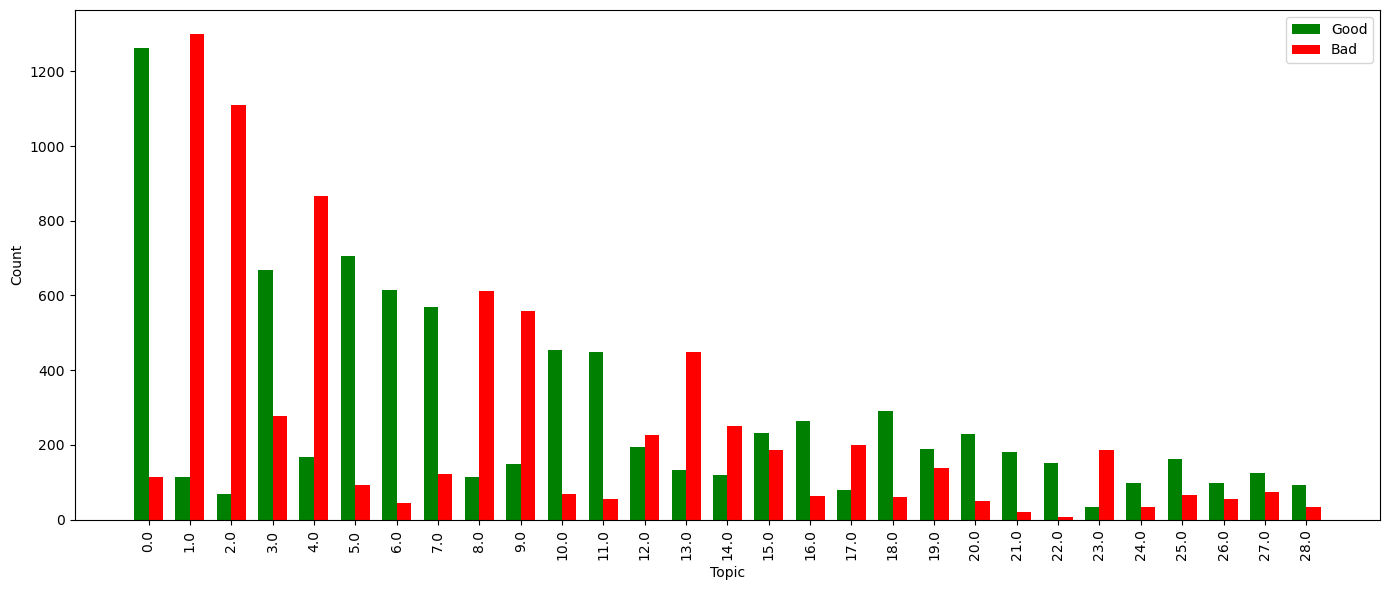

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Bar Chart Plot
good_counts = good['topic_title_abs_30'].value_counts().sort_index()
bad_counts = bad['topic_title_abs_30'].value_counts().sort_index()

topics = good_counts.index
x = np.arange(len(topics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, good_counts.values, width, label='Good', color='green')
bars2 = ax.bar(x + width/2, bad_counts.values, width, label='Bad', color='red')

ax.set_xlabel('Topic')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


Adding Topic Braodness

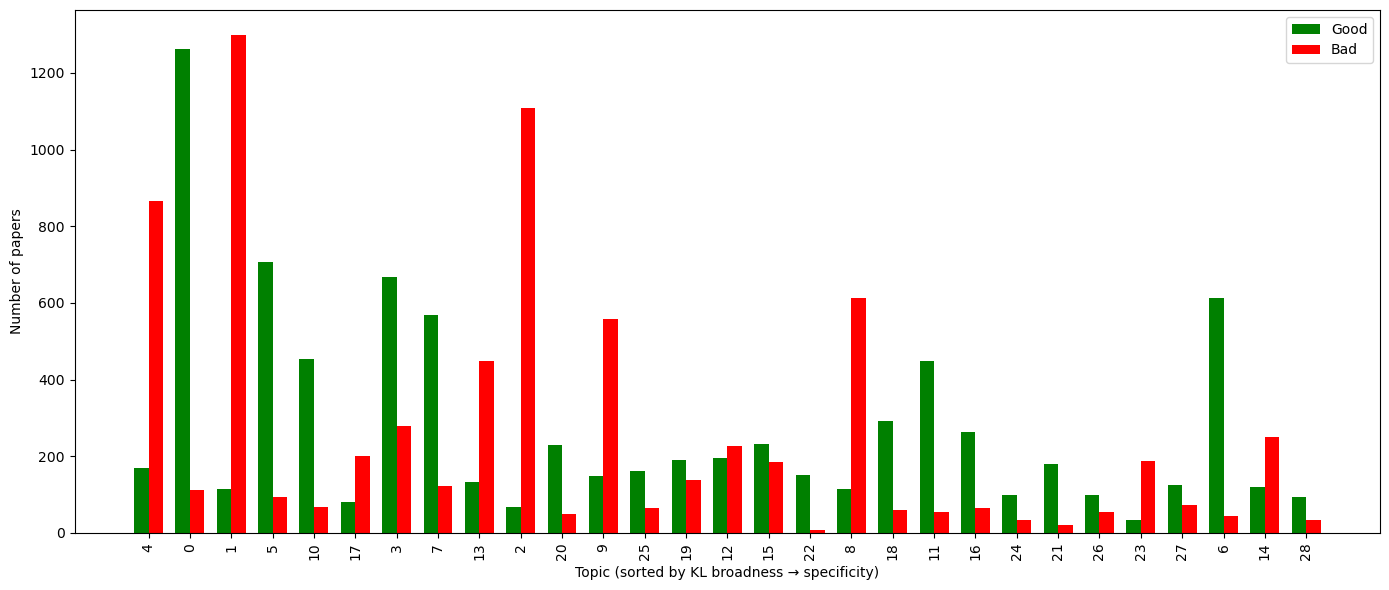

In [233]:
import matplotlib.pyplot as plt
import numpy as np

kl_order = topic_scores_df.sort_values("corpus_dist_norm", ascending=True)["topic_id"].values

good_ordered = good_counts.reindex(kl_order).fillna(0)
bad_ordered  = bad_counts .reindex(kl_order).fillna(0)

x = np.arange(len(kl_order))
width = 0.35

fig, ax = plt.subplots(figsize=(14,6))
ax.bar(x - width/2, good_ordered.values, width, label='Good', color='green')
ax.bar(x + width/2, bad_ordered.values,  width, label='Bad',  color='red')

ax.set_xlabel('Topic (sorted by KL broadness → specificity)')
ax.set_ylabel('Number of papers')
ax.set_xticks(x)
ax.set_xticklabels(kl_order, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


    topic_id  hier_score  hier_norm  hier_norm_rank
0          0    0.541786   0.386812            0.24
1          1    0.401491   0.000000            0.00
2          2    0.401491   0.000000            0.00
3          3    0.518661   0.323054            0.20
4          4    0.432911   0.086629            0.04
5          5    0.689400   0.793803            0.72
6          6    0.650755   0.687254            0.52
7          7    0.606436   0.565059            0.44
8          8    0.481292   0.220021            0.16
9          9    0.452359   0.140249            0.08
10        10    0.561836   0.442093            0.28
11        11    0.671096   0.743338            0.68
12        12    0.669064   0.737735            0.64
13        13    0.472436   0.195604            0.12
14        14    0.650755   0.687254            0.52
15        15    0.656691   0.703619            0.56
16        16    0.605741   0.563145            0.40
17        17    0.671096   0.743338            0.68
18        18

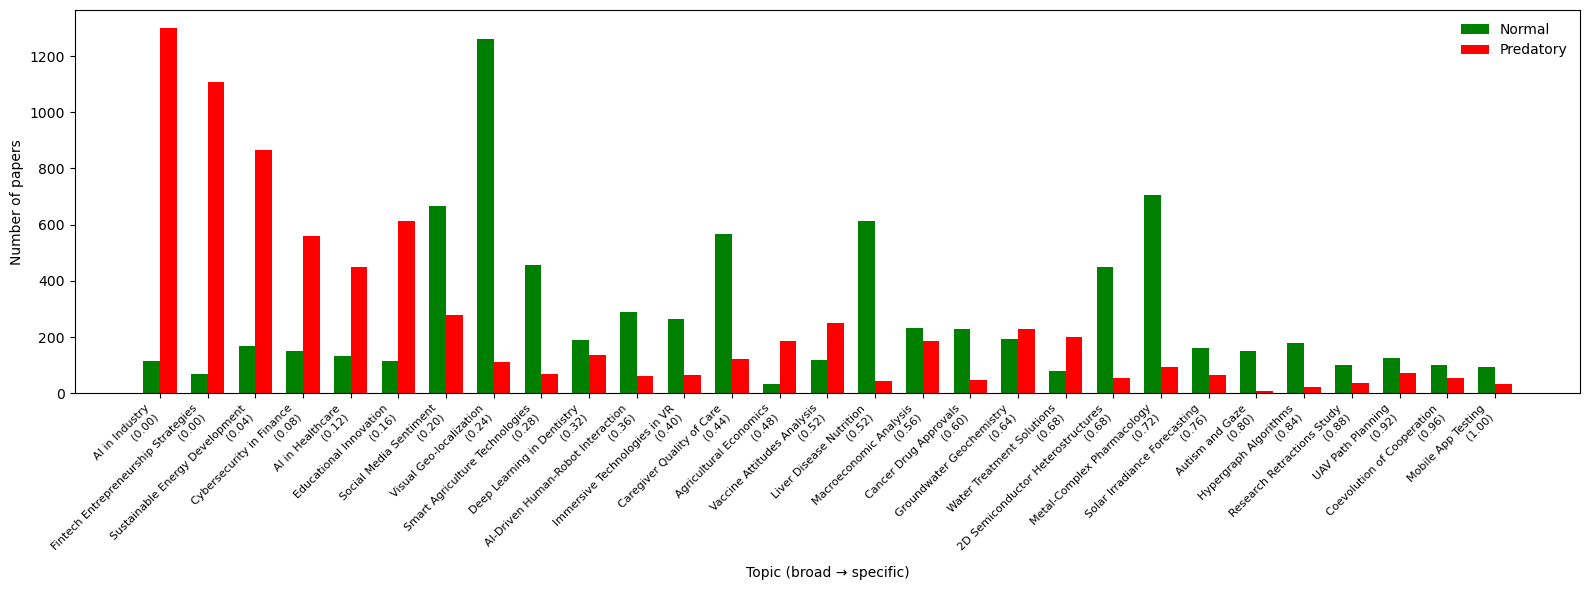

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage

c_tf_idf     = model.c_tf_idf_                      # shape = [(K+1), V]
row_sums      = np.asarray(c_tf_idf.sum(axis=1)).ravel()
row_sums[row_sums == 0] = 1
phi_all       = c_tf_idf.multiply(1/row_sums[:, None]).toarray()
topic_labels  = list(map(int, model.topic_labels_))
mask          = [lbl != -1 for lbl in topic_labels]
phi           = phi_all[mask, :]                    # shape = [K, V]

distances = pdist(phi, metric='cosine')

Z = linkage(distances, method='single')

def hierarchical_score(linkage_matrix, n_topics):
    scores = np.zeros(n_topics)
    for c1, c2, dist, _ in linkage_matrix:
        i1, i2 = int(c1), int(c2)
        if i1 < n_topics and scores[i1] == 0:
            scores[i1] = dist
        if i2 < n_topics and scores[i2] == 0:
            scores[i2] = dist
    return scores

n_topics    = phi.shape[0]
hier_scores = hierarchical_score(Z, n_topics)
hier_norm   = (hier_scores - hier_scores.min()) / (hier_scores.max() - hier_scores.min())

df_hier = pd.DataFrame({
    'topic_id':   np.arange(n_topics),
    'hier_score': hier_scores,
    'hier_norm':  hier_norm
})

ranks = ss.rankdata(hier_scores, method="dense") - 1
df_hier['hier_norm_rank'] = ranks / ranks.max()

print(df_hier)

good_counts = good['topic_title_abs_30'].value_counts().sort_index()
bad_counts  = bad ['topic_title_abs_30'].value_counts().sort_index()

hier_order = df_hier.sort_values('hier_norm_rank', ascending=True)['topic_id'].values

topic_names = {
    0: "Visual Geo-localization",
    1: "AI in Industry",
    2: "Fintech Entrepreneurship Strategies",
    3: "Social Media Sentiment",
    4: "Sustainable Energy Development",
    5: "Metal-Complex Pharmacology",
    6: "Liver Disease Nutrition",
    7: "Caregiver Quality of Care",
    8: "Educational Innovation",
    9: "Cybersecurity in Finance",
    10: "Smart Agriculture Technologies",
    11: "2D Semiconductor Heterostructures",
    12: "Groundwater Geochemistry",
    13: "AI in Healthcare",
    14: "Vaccine Attitudes Analysis",
    15: "Macroeconomic Analysis",
    16: "Immersive Technologies in VR",
    17: "Water Treatment Solutions",
    18: "AI-Driven Human-Robot Interaction",
    19: "Deep Learning in Dentistry",
    20: "Cancer Drug Approvals",
    21: "Hypergraph Algorithms",
    22: "Autism and Gaze",
    23: "Agricultural Economics",
    24: "Research Retractions Study",
    25: "Solar Irradiance Forecasting",
    26: "Coevolution of Cooperation",
    27: "UAV Path Planning",
    28: "Mobile App Testing",

}

good_ord = good_counts.reindex(hier_order).fillna(0)
bad_ord  = bad_counts .reindex(hier_order).fillna(0)
labels   = [
    f"{topic_names[t]}\n({df_hier.loc[df_hier.topic_id==t, 'hier_norm_rank'].values[0]:.2f})"
    for t in hier_order
]

x     = np.arange(len(hier_order))
width = 0.35

fig, ax = plt.subplots(figsize=(16,6))
ax.bar(x - width/2, good_ord.values, width, label='Normal', color='green')
ax.bar(x + width/2, bad_ord.values,  width, label='Predatory',  color='red')

ax.set_xlabel('Topic (broad → specific)')
ax.set_ylabel('Number of papers')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


Statistics test across dataset (Hierarchical version)

In [246]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from scipy.stats import ttest_ind

_, probs = model.transform(docs)

c_tf_idf = model.c_tf_idf_
row_sums  = np.asarray(c_tf_idf.sum(axis=1)).ravel()
row_sums[row_sums == 0] = 1
phi_all   = c_tf_idf.multiply(1/row_sums[:,None]).toarray()
labels    = list(map(int, model.topic_labels_))
mask      = [lbl != -1 for lbl in labels]
phi       = phi_all[mask, :]  # (K, V)

distances = pdist(phi, metric='cosine')
Z         = linkage(distances, method='single')
def hier_score(Z, K):
    s = np.zeros(K)
    for c1, c2, dist, _ in Z:
        i1, i2 = int(c1), int(c2)
        if i1<K and s[i1]==0: s[i1]=dist
        if i2<K and s[i2]==0: s[i2]=dist
    return s

K          = phi.shape[0]
hier_scores = hier_score(Z, K)
hier_norm   = (hier_scores - hier_scores.min()) / (hier_scores.max() - hier_scores.min())

combined_papers['doc_hier_score'] = probs.dot(hier_norm)

bad_scores  = combined_papers.loc[combined_papers.dataset=='bad',  'doc_hier_score']
good_scores = combined_papers.loc[combined_papers.dataset=='good','doc_hier_score']

desc = pd.DataFrame({
    'Group': ['Predatory', 'Normal'],
    'N':     [len(bad_scores), len(good_scores)],
    'Mean':  [bad_scores.mean(), good_scores.mean()],
    'Std':   [bad_scores.std(),  good_scores.std()]
})
t_stat, p_val = ttest_ind(bad_scores, good_scores, equal_var=False)
pooled_sd = np.sqrt(((len(bad)-1)*bad_scores.std()**2 + (len(good_scores)-1)*good_scores.std()**2) 
                    / (len(bad)+len(good_scores)-2))
cohens_d = (good_scores.mean() - bad_scores.mean()) / pooled_sd

print(desc.to_string(index=False))
print(f"\nStudent’s t-test (unequal var): t = {t_stat:.3f}, p = {p_val:.3e}")
print(f"Cohen’s d = {cohens_d:.3f}")


    Group    N     Mean      Std
Predatory 7728 0.166924 0.197202
   Normal 8299 0.359517 0.249761

Student’s t-test (unequal var): t = -54.368, p = 0.000e+00
Cohen’s d = 0.850


Threshold of Broadness, and Test “specific”（hier_norm ≥ best_thresh）ratio

—— 75% quantile ——
Threshold = 0.704
  Pred over: 1104/7326 = 15.07%
  Norm over: 2804/8014 = 34.99%

—— Elbow ——
Threshold = 1.000
  Pred over: 34/7326 = 0.46%
  Norm over: 94/8014 = 1.17%

—— GMM Mid ——
Threshold = 0.431
  Pred over: 2039/7326 = 27.83%
  Norm over: 5340/8014 = 66.63%

—— KMeans Mid ——
Threshold = 0.430
  Pred over: 2039/7326 = 27.83%
  Norm over: 5340/8014 = 66.63%



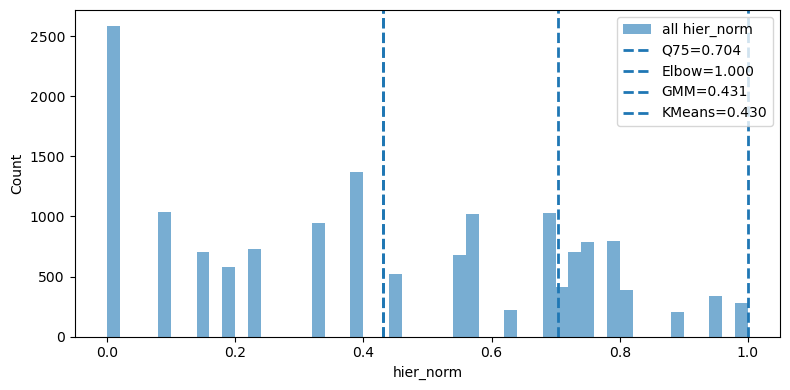

In [ ]:
import numpy as np
import pandas as pd
from kneed import KneeLocator
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

score_map   = df_hier.set_index('topic_id')['hier_norm']
norm_scores = good['topic_title_abs_30'].map(score_map).values
pred_scores = bad ['topic_title_abs_30'].map(score_map).values
all_scores  = np.concatenate([pred_scores, norm_scores])

th_q75 = np.quantile(all_scores, 0.75)

vals = np.sort(all_scores)
kl   = KneeLocator(range(len(vals)), vals, curve="convex", direction="increasing")
th_elbow = vals[kl.knee]

X = all_scores.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
means = np.sort(gmm.means_.ravel())
th_gmm = means.mean()

km = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans_means = np.sort(km.cluster_centers_.ravel())
th_km = kmeans_means.mean()

def report_thresh(thresh):
    pred_over = (pred_scores >= thresh).sum()
    norm_over = (norm_scores >= thresh).sum()
    print(f"Threshold = {thresh:.3f}")
    print(f"  Pred over: {pred_over}/{len(pred_scores)} = {pred_over/len(pred_scores):.2%}")
    print(f"  Norm over: {norm_over}/{len(norm_scores)} = {norm_over/len(norm_scores):.2%}")
    print()

print("—— 75% quantile ——")
report_thresh(th_q75)

print("—— Elbow ——")
report_thresh(th_elbow)

print("—— GMM Mid ——")
report_thresh(th_gmm)

print("—— KMeans Mid ——")
report_thresh(th_km)

plt.figure(figsize=(8,4))
plt.hist(all_scores, bins=50, alpha=0.6, label='all hier_norm')
for t, name in [(th_q75, 'Q75'), (th_elbow, 'Elbow'), (th_gmm, 'GMM'), (th_km, 'KMeans')]:
    plt.axvline(t, linestyle='--', linewidth=2, label=f"{name}={t:.3f}")
plt.xlabel('hier_norm')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

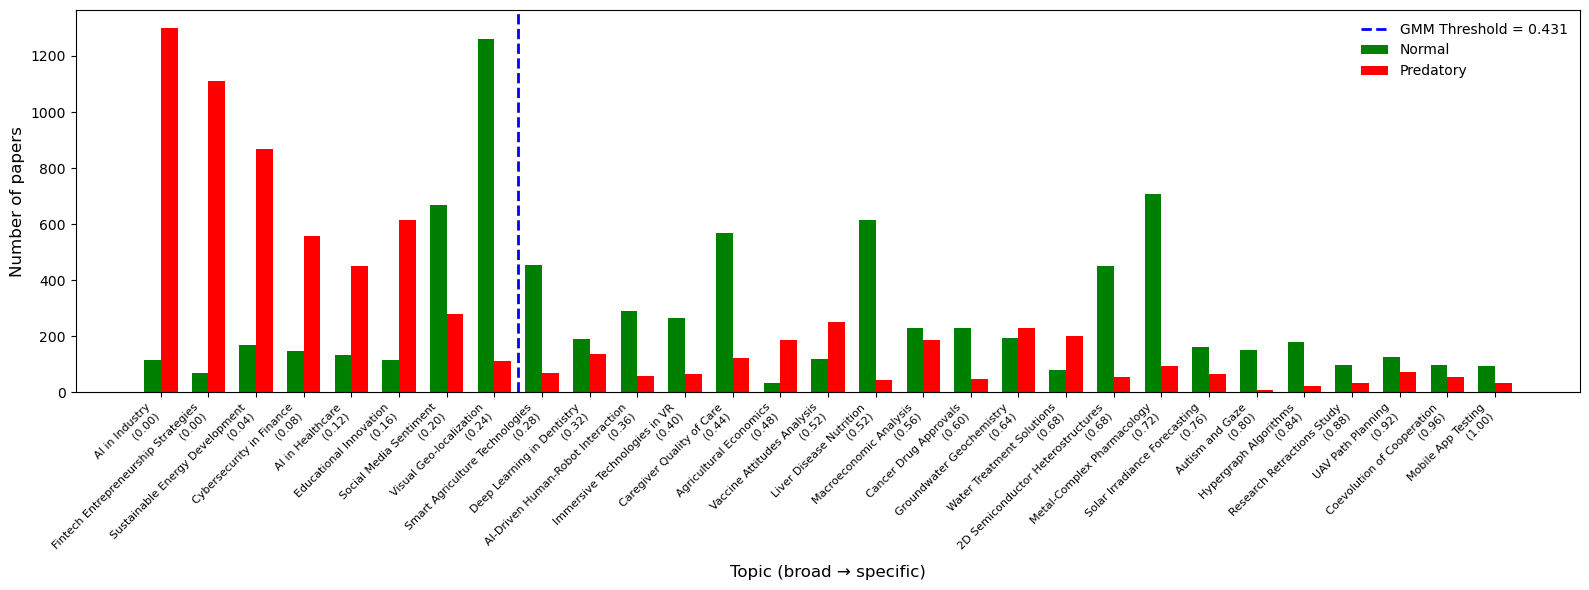

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from sklearn.mixture import GaussianMixture

c_tf_idf    = model.c_tf_idf_
row_sums     = np.asarray(c_tf_idf.sum(axis=1)).ravel()
row_sums[row_sums == 0] = 1
phi_all      = c_tf_idf.multiply(1/row_sums[:, None]).toarray()
topic_labels = list(map(int, model.topic_labels_))
mask         = [lbl != -1 for lbl in topic_labels]
phi          = phi_all[mask, :]

distances = pdist(phi, metric='cosine')
Z = linkage(distances, method='single')

def hierarchical_score(Z, n):
    scores = np.zeros(n)
    for c1, c2, d, _ in Z:
        i1, i2 = int(c1), int(c2)
        if i1 < n and scores[i1] == 0: scores[i1] = d
        if i2 < n and scores[i2] == 0: scores[i2] = d
    return scores

n_topics    = phi.shape[0]
hier_scores = hierarchical_score(Z, n_topics)
hier_norm   = (hier_scores - hier_scores.min()) / (hier_scores.max() - hier_scores.min())

df_hier = pd.DataFrame({
    'topic_id':      np.arange(n_topics),
    'hier_score':    hier_scores,
    'hier_norm':     hier_norm
})

ranks = ss.rankdata(hier_scores, method="dense") - 1
df_hier['hier_norm_rank'] = ranks / ranks.max()

good_counts = good['topic_title_abs_30'].value_counts().sort_index()
bad_counts  = bad ['topic_title_abs_30'].value_counts().sort_index()

hier_order = df_hier.sort_values('hier_norm_rank', ascending=True)['topic_id'].values

topic_names = {
    0: "Visual Geo-localization",
    1: "AI in Industry",
    2: "Fintech Entrepreneurship Strategies",
    3: "Social Media Sentiment",
    4: "Sustainable Energy Development",
    5: "Metal-Complex Pharmacology",
    6: "Liver Disease Nutrition",
    7: "Caregiver Quality of Care",
    8: "Educational Innovation",
    9: "Cybersecurity in Finance",
    10: "Smart Agriculture Technologies",
    11: "2D Semiconductor Heterostructures",
    12: "Groundwater Geochemistry",
    13: "AI in Healthcare",
    14: "Vaccine Attitudes Analysis",
    15: "Macroeconomic Analysis",
    16: "Immersive Technologies in VR",
    17: "Water Treatment Solutions",
    18: "AI-Driven Human-Robot Interaction",
    19: "Deep Learning in Dentistry",
    20: "Cancer Drug Approvals",
    21: "Hypergraph Algorithms",
    22: "Autism and Gaze",
    23: "Agricultural Economics",
    24: "Research Retractions Study",
    25: "Solar Irradiance Forecasting",
    26: "Coevolution of Cooperation",
    27: "UAV Path Planning",
    28: "Mobile App Testing",
}

good_ord = good_counts.reindex(hier_order).fillna(0)
bad_ord  = bad_counts .reindex(hier_order).fillna(0)
labels   = [
    f"{topic_names[t]}\n({df_hier.loc[df_hier.topic_id==t, 'hier_norm_rank'].values[0]:.2f})"
    for t in hier_order
]

all_scores = np.concatenate([
    good['topic_title_abs_30'].map(df_hier.set_index('topic_id')['hier_norm']).values,
    bad ['topic_title_abs_30'].map(df_hier.set_index('topic_id')['hier_norm']).values
]).reshape(-1,1)
gmm = GaussianMixture(n_components=2, random_state=0).fit(all_scores)
means = np.sort(gmm.means_.ravel())
threshold = means.mean()  

sorted_norms = df_hier.set_index('topic_id').loc[hier_order, 'hier_norm'].values
split_idx = np.argmax(sorted_norms >= threshold)  

x     = np.arange(len(hier_order))
width = 0.35

fig, ax = plt.subplots(figsize=(16,6))
ax.bar(x - width/2, good_ord.values, width, label='Normal',    color='green')
ax.bar(x + width/2, bad_ord.values,  width, label='Predatory', color='red')

ax.axvline(split_idx - 0.5, color='blue', linestyle='--', linewidth=2,
           label=f"GMM Threshold = {threshold:.3f}")

ax.set_xlabel('Topic (broad → specific)', fontsize=12)
ax.set_ylabel('Number of papers', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from math import asin, sqrt

threshold = 0.431 

pred_pos = (pred_scores >= threshold).sum()  
pred_neg = (pred_scores <  threshold).sum()   
norm_pos = (norm_scores >= threshold).sum()   
norm_neg = (norm_scores <  threshold).sum()   


table = np.array([[pred_pos, pred_neg],
                  [norm_pos, norm_neg]])
print("Contingency Table (rows: Pred,Norm; cols: Spec,Broad):")
print(table)

counts = np.array([norm_pos, pred_pos])
nobs   = np.array([len(norm_scores), len(pred_scores)])
z_stat, p_val = proportions_ztest(counts, nobs, alternative='larger')
print(f"\nProportions Z-Test:")
print(f" z = {z_stat:.3f}, p = {p_val:.3e}")

chi2, chi_p, dof, expected = chi2_contingency(table)
print(f"\nChi-Square Test:")
print(f" χ² = {chi2:.3f}, p = {chi_p:.3e}, dof = {dof}")

N = table.sum()
phi = sqrt(chi2 / N)
print(f" Phi coefficient = {phi:.3f}")

pred_prop = pred_pos / len(pred_scores)
norm_prop = norm_pos / len(norm_scores)
h = 2*asin(sqrt(norm_prop)) - 2*asin(sqrt(pred_prop))
print(f" Cohen’s h = {h:.3f}")


Contingency Table (rows: Pred,Norm; cols: Spec,Broad):
[[2039 5287]
 [5340 2674]]

Proportions Z-Test:
 z = 48.043, p = 0.000e+00

Chi-Square Test:
 χ² = 2306.589, p = 0.000e+00, dof = 1
 Phi coefficient = 0.388
 Cohen’s h = 0.798


<h3>Generate Topic Name</h3>

In [ ]:
import openai
import os
import pandas as pd
import time
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

openai.api_key = "your API"  

In [ ]:
import openai

assistant = openai.beta.assistants.create(
    name="BERTopic Labeling Assistant",
    instructions="""
    Your task is to generate a short and clear label for a research topic. Each topic includes a list of representative keywords and a few representative document titles.

    **Response Format**: Return only a concise, high-level label (1 short phrase, no more than 3 words). Do not include any extra text or explanations.
    """,
    model="gpt-4o-mini",
)

assistant_id = assistant.id  


In [239]:
def get_topic_label(documents, keywords, assistant_id):
    """
    Generates a short label for a BERTopic topic.

    Parameters:
        documents (str): Representative document titles for the topic.
        keywords (str): Representative keywords for the topic.
        assistant_id (str): The ID of the pre-created assistant.

    Returns:
        str: A concise topic label.
    """
    try:
        # Create a thread for this topic labeling
        thread = openai.beta.threads.create()

        # Format the message
        message = f"""
        I have topic that contains the following documents: 
        {documents}

        The topic is described by the following keywords: 
        {keywords}

        Based on the above information, can you give a short label of the topic?
        """

        # Send user message
        openai.beta.threads.messages.create(
            thread_id=thread.id,
            role="user",
            content=message.strip(),
        )

        # Run the assistant
        run = openai.beta.threads.runs.create_and_poll(
            thread_id=thread.id,
            assistant_id=assistant_id
        )

        # Process the response
        if run.status == "completed":
            messages = openai.beta.threads.messages.list(thread_id=thread.id)
            for response in messages:
                if response.role == "assistant":
                    label = response.content[0].text.value.strip()
                    openai.beta.threads.delete(thread.id)  # Clean up
                    return label

        openai.beta.threads.delete(thread.id)
        return "Unknown"

    except Exception as e:
        print(f"Error generating topic label: {e}")
        return "Unknown"

In [ ]:
def label_all_topics(df, assistant_id):
    """
    Loop through BERTopic DataFrame and get labels for each topic.

    Parameters:
        df (pd.DataFrame): Output from topic_model.get_topic_info()
        assistant_id (str): ID of the assistant used for labeling.

    Returns:
        dict: Mapping of topic number to generated label.
    """
    topic_labels = {}

    for _, row in df.iterrows():
        topic = row["Topic"]
        if topic == -1:  
            continue
        keywords = row["Representation"]
        documents = row["Representative_Docs"]
        label = get_topic_label(documents, keywords, assistant_id)
        print(f"Topic {topic}: {label}")
        topic_labels[topic] = label

    return topic_labels

In [ ]:
topic_info_df.to_csv('data/topic_generationabstract30_info.csv', index=False)

In [242]:
labels = label_all_topics(topic_info_df, assistant_id)

/tmp/ipykernel_236498/1113172292.py:15: DeprecationWarning:

The Assistants API is deprecated in favor of the Responses API

/tmp/ipykernel_236498/1113172292.py:29: DeprecationWarning:

The Assistants API is deprecated in favor of the Responses API

/tmp/ipykernel_236498/1113172292.py:36: DeprecationWarning:

The Assistants API is deprecated in favor of the Responses API

/tmp/ipykernel_236498/1113172292.py:43: DeprecationWarning:

The Assistants API is deprecated in favor of the Responses API

/tmp/ipykernel_236498/1113172292.py:47: DeprecationWarning:

The Assistants API is deprecated in favor of the Responses API



Topic 0: Visual Geo-localization
Topic 1: AI in Industry
Topic 2: Fintech Entrepreneurship Strategies
Topic 3: Social Media Sentiment
Topic 4: Sustainable Energy Development
Topic 5: Metal-Complex Pharmacology
Topic 6: Liver Disease Nutrition
Topic 7: Caregiver Quality of Care
Topic 8: Educational Innovation
Topic 9: Cybersecurity in Finance
Topic 10: Smart Agriculture Technologies
Topic 11: 2D Semiconductor Heterostructures
Topic 12: Groundwater Geochemistry
Topic 13: AI in Healthcare
Topic 14: Vaccine Attitudes Analysis
Topic 15: Macroeconomic Analysis
Topic 16: Immersive Technologies in VR
Topic 17: Water Treatment Solutions
Topic 18: AI-Driven Human-Robot Interaction
Topic 19: Deep Learning in Dentistry
Topic 20: Cancer Drug Approvals
Topic 21: Hypergraph Algorithms
Topic 22: Autism and Gaze
Topic 23: Agricultural Economics
Topic 24: Research Retractions Study
Topic 25: Solar Irradiance Forecasting
Topic 26: Coevolution of Cooperation
Topic 27: UAV Path Planning
Topic 28: Mobile Ap